In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
df = pd.read_csv('monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv')

In [195]:
df['MONAT'] = pd.to_datetime(df['MONAT'].astype(str), format='%Y%m')

In [196]:
df.set_index(df['MONAT'], inplace=True)

In [197]:
df_train = df[(df['MONATSZAHL'] == 'Alkoholunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt') & (df['JAHR'] <= 2020)]

In [198]:
df_test = df[(df['MONATSZAHL'] == 'Alkoholunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt') & (df['JAHR'] == 2021)]

In [199]:
df_train = df_train.drop(['MONATSZAHL','MONAT', 'AUSPRAEGUNG','JAHR', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'], axis=1)

In [200]:
df_test = df_test.drop(['MONATSZAHL','MONAT', 'AUSPRAEGUNG','JAHR', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'], axis=1)

In [201]:
df_train.sort_index(inplace=True)

In [202]:
df_test.sort_index(inplace=True)

In [203]:
df_train

,WERT
MONAT,
2000-01-01,78.0
2000-02-01,53.0
2000-03-01,73.0
2000-04-01,78.0
2000-05-01,96.0
...,...
2020-08-01,46.0
2020-09-01,46.0
2020-10-01,34.0


<Axes: xlabel='MONAT'>

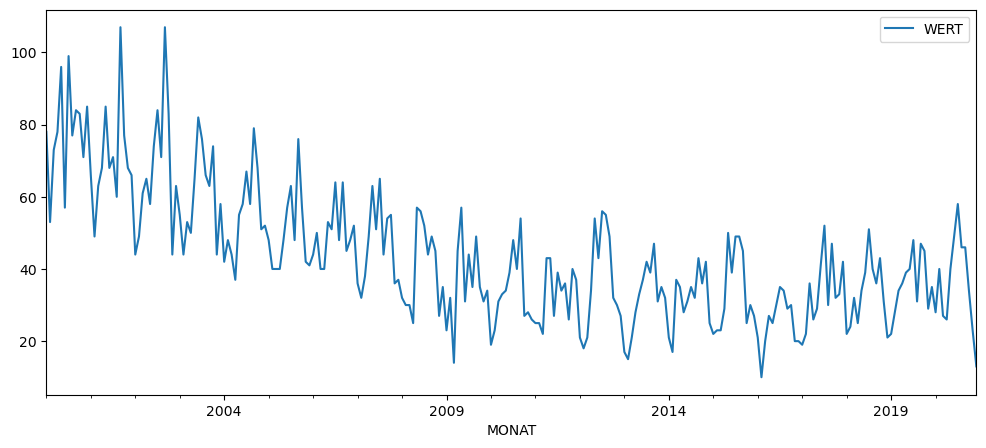

In [204]:
df_train.plot(figsize=(12,5))

In [205]:
#Data is deffinetly not stationary. And i would guess that the seasonality is additive. So no log transformation is needed.since the seasonality seems to be quite strong i would guess that seasonal differencing should be applied

In [206]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [207]:
results= adfuller(df_train)

In [208]:
results

(-2.778474040626489,
 0.06141499421706842,
 13,
 238,
 {'1%': -3.458128284586202,
  '5%': -2.873761835239286,
  '10%': -2.5732834559706235},
 1695.196302896559)

In [209]:
#okay but not by far. maybe we don't even have to transform the data at all.

In [210]:
df_diff= df_train.diff().dropna()

In [211]:
results2= adfuller(df_diff)

In [212]:
results2

(-4.549297016362372,
 0.00016001189638459608,
 16,
 234,
 {'1%': -3.4586084859607156,
  '5%': -2.873972159235721,
  '10%': -2.57339565928848},
 1695.0474760822262)

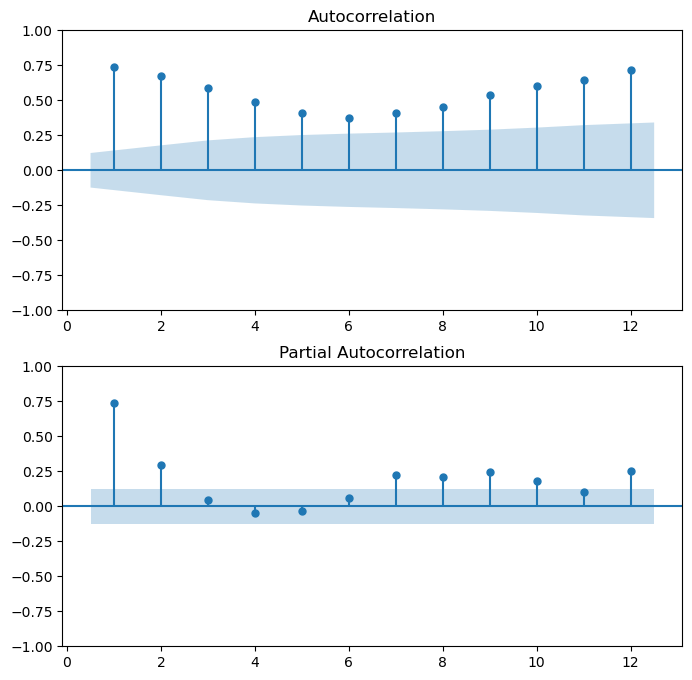

In [213]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(df_train, ax=ax1, lags=12, zero=False)
plot_pacf(df_train, ax=ax2, lags=12, zero=False)
plt.show()

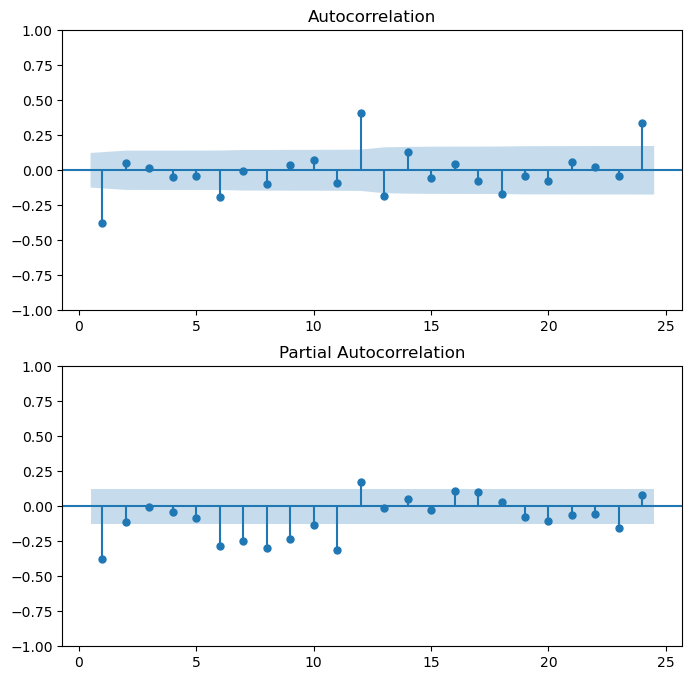

In [214]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(df_diff, ax=ax1, lags=24, zero=False)
plot_pacf(df_diff, ax=ax2, lags=24, zero=False)
plt.show()

In [215]:
#There is deffinetly some seasonality

In [216]:
decomp_res= seasonal_decompose(df_train, period= 14)

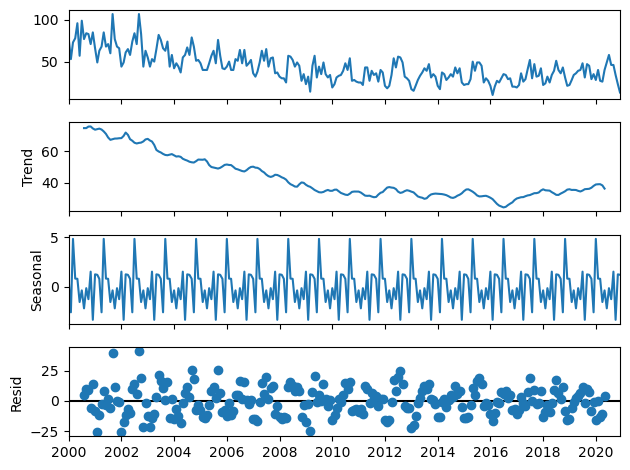

In [217]:
decomp_res.plot()
plt.show()

In [218]:
#Clearly showing the trend and seasonality

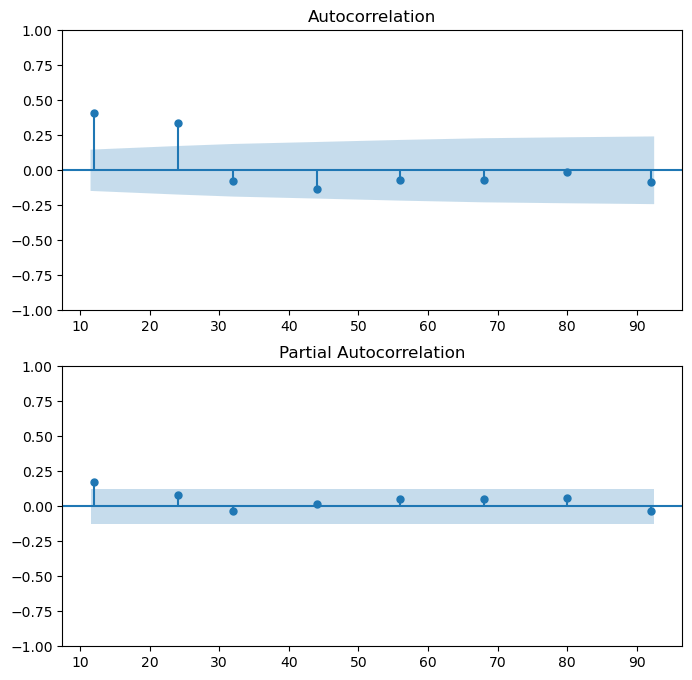

In [219]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(df_diff, ax=ax1, lags=[12,24,32,44,56,68,80,92], zero=False)
plot_pacf(df_diff, ax=ax2, lags=[12,24,32,44,56,68,80,92], zero=False)
plt.show()

In [220]:
results= pm.auto_arima(df_train, d=1, start_p=1, start_1=1, max_p=5, max_q=5, seasonal=True, m=12, D=1, start_P=1, start_Q=1,max_P=5, max_Q=5, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=1718.496, Time=1.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1914.265, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1817.563, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1716.584, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1809.685, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1717.913, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1717.884, Time=1.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1749.351, Time=0.38 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1719.882, Time=1.43 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1827.466, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1716.101, Time=0.63 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1803.399, Time=0.24 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1717.624, Time=0.98 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1717.593, Time=1.48 sec
 ARIMA(1,1,1)(1,1,0

In [221]:
np.mean(np.absolute(results.resid()))

7.65973119489923

In [222]:
results2= pm.auto_arima(df_train, d=0, start_p=1, start_1=1, max_p=3, max_q=3, seasonal=True, m=12, D=1, start_P=1, start_Q=1,max_P=3, max_Q=3, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1725.424, Time=3.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1817.937, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1761.847, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1755.899, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1825.190, Time=0.06 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1723.731, Time=2.50 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=1810.963, Time=0.64 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=1725.412, Time=4.59 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=1755.024, Time=1.86 sec
 ARIMA(1,0,2)(1,1,2)[12] intercept   : AIC=inf, Time=5.41 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1755.941, Time=0.94 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1724.544, Time=2.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(1,0,3)(0,1,1)[12] intercept   : AIC=1724.683, Time=2.81 sec
 ARIMA(0,0,3)(0,1,1)[12] inte

In [223]:
np.mean(np.absolute(results2.resid()))

10.054266366883324

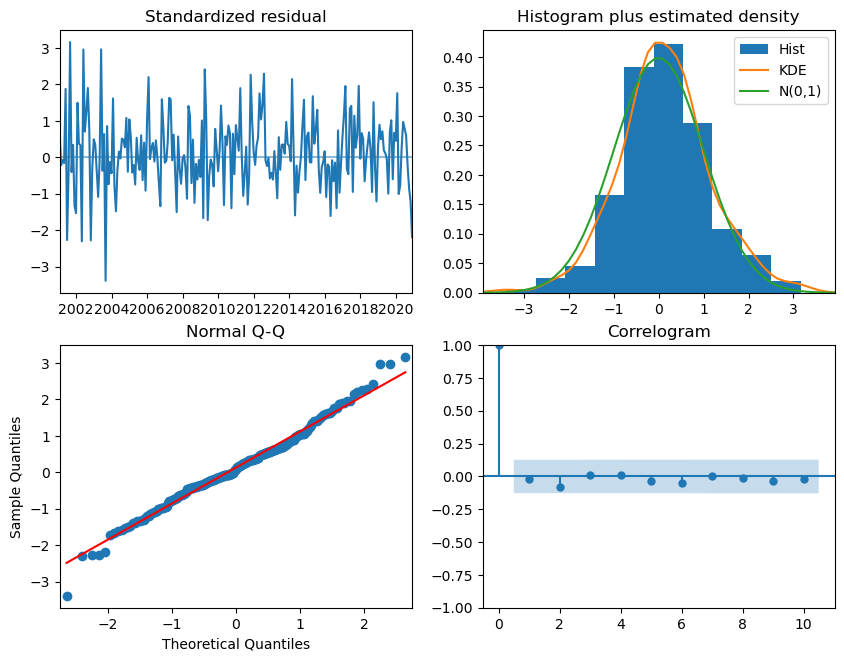

In [224]:
results.plot_diagnostics(figsize=(10,7.5))
plt.show()

In [225]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  252
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -853.819
Date:                              Sat, 23 Dec 2023   AIC                           1715.638
Time:                                      11:24:19   BIC                           1729.544
Sample:                                  01-01-2000   HQIC                          1721.242
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7841      0.067    -11.708      0.000      -0.915      -0.653
ma.L2         -0.1202      0.067     -1.787      0.074      -0.252       0.012
ma.S.L12      -0.7491      0.063    -11.833      0.000      -0.873      -0.625
sigma2        70.5616      5.702     12.375      0.000      59.386      81.737
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 6.06
Prob(Q):                              0.74   Prob(JB):                         0.05
Heteroskedasticity (H):               0.60   Skew:                             0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
#Prob(JB) is just at the edge indicating that the residuals are not normally distributed. although my guess is that the outliers from the Q-Q curve are responsible. One could eliminate the outliers and retrain the model. 

In [227]:
sarima  = SARIMAX(df_train, order=(0,1,2), seasonal_order=(0,1,1,12))

C:\Users\l_san\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\l_san\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [228]:
results= sarima.fit()

In [229]:
np.mean(np.absolute(results.resid))

7.65973119489923

In [230]:
train_pred= results.get_prediction(start=-25)
#one step ahead predictions on training set

In [231]:
mean_train_pred = train_pred.predicted_mean

In [232]:
conf_int_train= train_pred.conf_int()

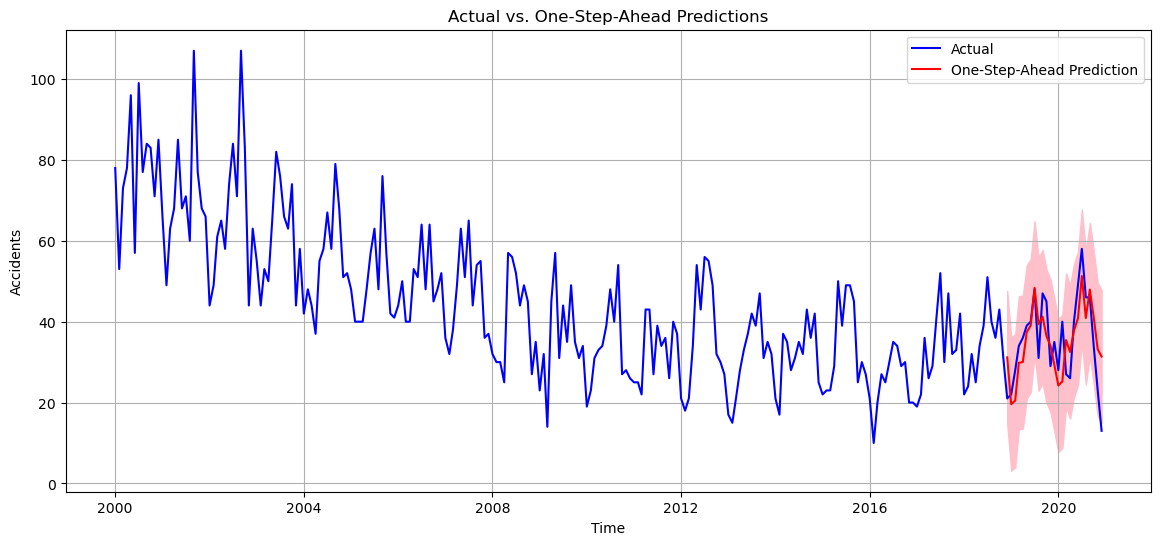

In [233]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_train.index, df_train, label='Actual', color='blue')
plt.plot(mean_train_pred.index, mean_train_pred.values, label='One-Step-Ahead Prediction', color='red')
plt.fill_between(mean_train_pred.index, conf_int_train['lower WERT'], conf_int_train['upper WERT'], color='pink')
plt.xlabel('Time')
plt.ylabel('Accidents') 
plt.legend()
plt.title('Actual vs. One-Step-Ahead Predictions')
plt.grid(True)

plt.show()


In [234]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [235]:
test_pred = results.get_forecast(steps=12)

In [236]:
mean_pred_test = test_pred.predicted_mean

In [237]:
conf_int_test = test_pred.conf_int()

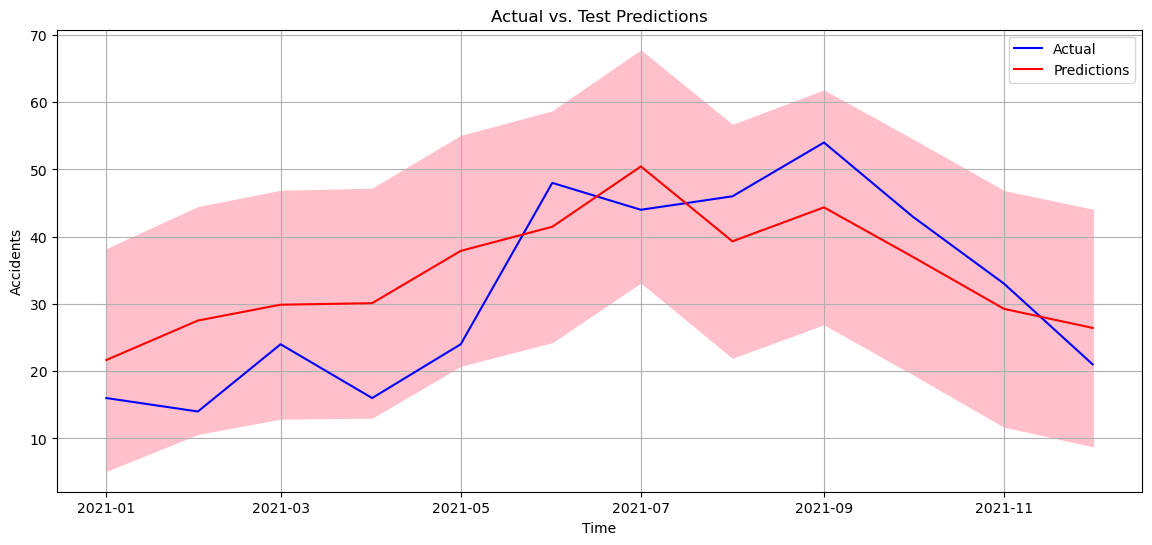

In [238]:
plt.figure(figsize=(14, 6))
plt.plot(df_test.index, df_test, label='Actual', color='blue')
plt.plot(mean_pred_test.index, mean_pred_test.values, label='Predictions', color='red')
plt.fill_between(mean_pred_test.index, conf_int_test['lower WERT'], conf_int_test['upper WERT'], color='pink')
plt.xlabel('Time')
plt.ylabel('Accidents') 
plt.legend()
plt.title('Actual vs. Test Predictions')
plt.grid(True)

plt.show()

In [239]:
mse_test= mean_squared_error(df_test, mean_pred_test)
mse_test

78.55191412366837

In [240]:
mae_test = mean_absolute_error(df_test, mean_pred_test)
mae_test

8.12636708659989

In [241]:
import joblib
joblib.dump(results, 'sarima')

['sarima']

In [250]:
np.savetxt("test_point.csv", df_test.index, delimiter=',' , fmt='%d')

In [251]:
with open("test_point.csv", "r") as f:
    test = np.loadtxt(f, delimiter=',')

In [252]:
print(test)

[1.6094592e+18 1.6121376e+18 1.6145568e+18 1.6172352e+18 1.6198272e+18
 1.6225056e+18 1.6250976e+18 1.6277760e+18 1.6304544e+18 1.6330464e+18
 1.6357248e+18 1.6383168e+18]


In [253]:
bt1= joblib.load('sarima')

In [259]:
def predict_for_date(year, month, model=results, data=df_train):
    target_date = pd.Timestamp(year=year, month=month, day=1)
    last_known_date = data.index[-1]
    
    months_diff = (target_date.year - last_known_date.year) * 12 + target_date.month - last_known_date.month
    if months_diff > 0:
        prediction = model.get_forecast(steps=months_diff).predicted_mean.iloc[-1]
    else:
        prediction = data.loc[target_date.strftime('%Y-%m-%d')] if target_date in data.index else None
    
    return prediction


In [262]:
year = 2021
month = 1
predict_for_date(year, month)


21.65662600565763

In [266]:
test_dates = pd.to_datetime(test, unit='ns')

predictions = []

for test_date in test_dates:
    year = test_date.year
    month = test_date.month
    prediction = predict_for_date(year, month)
    predictions.append(prediction)


In [267]:
predictions

[21.65662600565763,
 27.526967665257093,
 29.881307584730287,
 30.10940912209397,
 37.886425267469605,
 41.47189513204995,
 50.44452295166007,
 39.3085371625554,
 44.3549377830934,
 37.02108979084006,
 29.261148550377385,
 26.42875486124622]

In [268]:
df_train.index[-1]

Timestamp('2020-12-01 00:00:00')